In [19]:
import pandas as pd
import os
from os import listdir
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import scipy.stats as s
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")

work_dir = '/Users/xiaodanxu/Documents/SynthFirm.nosync'
os.chdir(work_dir)
meter_to_mile = 0.00062137
min_to_hour = 1/60
sec_to_hour = 1/3600

In [9]:
# load BEAM skim 
region = 'Austin'
skim_dir = 'RawData/BEAM_skims/' + region
skim_files = listdir(skim_dir)
beam_skim_out = None
var_to_keep = ['timePeriod', 'pathType',
               'origin', 'destination', 
               'TIME_minutes', 'DIST_meters']

var_to_keep_aus = ['hour', 'mode', 
                   'origTaz', 'destTaz', 
                   'travelTimeInS',
                   'distanceInM']
for file in skim_files:
    print(file)
    if file == '.DS_Store':
        continue
    beam_skim = read_csv(os.path.join(skim_dir, file))
    print(len(beam_skim))
    if region == 'SFBay':
        beam_skim = beam_skim.loc[beam_skim['pathType'] == 'SOV']
        beam_skim = beam_skim.loc[beam_skim['timePeriod'] == 'AM']
        beam_skim = beam_skim[var_to_keep]
    elif region == 'Austin':
        beam_skim = beam_skim.loc[beam_skim['mode'] == 'CAR']
        beam_skim = beam_skim.loc[beam_skim['hour'] == 7]
        beam_skim = beam_skim[var_to_keep_aus]
    print(len(beam_skim))
    beam_skim_out = pd.concat([beam_skim_out, beam_skim])
#     break
# print(beam_skim.columns)
beam_skim_out.head(5)

0.skimsOD.csv.gz
750769
26989
.DS_Store


,hour,mode,origTaz,destTaz,travelTimeInS,distanceInM
18,7,CAR,484530024221,484530011001,850.0,10059.711
36,7,CAR,484530017123,484530020042,284.0,3165.056
73,7,CAR,484910203231,484530018491,1732.0,26022.497
88,7,CAR,484910204053,484530017162,1296.0,17426.009
94,7,CAR,484530009023,484530009012,141.0,1618.452


In [7]:
beam_skim.head(5)

,hour,mode,rideHailName,origTaz,destTaz,travelTimeInS,generalizedTimeInS,cost,generalizedCost,distanceInM,payloadWeightInKg,energy,level4CavTravelTimeScalingFactor,failedTrips,observations,iterations
0,11,CAR,NaN,484530004012,484530024211,1197.0,1334.0,0.724558,3.411086,18578.411000,0.0,4.320284e+07,1.0,0,1,1
1,7,WALK,NaN,484530018332,484910201093,8293.0,8293.0,0.000000,16.701181,41466.658182,0.0,0.000000e+00,1.0,0,1,1
2,21,CAR,NaN,484530018391,484910203181,1196.0,2699.0,0.790165,6.225651,20260.634000,0.0,4.726030e+07,1.0,0,1,1
3,14,WALK,NaN,484530006011,484530002053,2678.0,2678.0,0.000000,5.393194,3481.269000,0.0,1.845073e+05,1.0,0,1,1
4,20,WALK,NaN,484530017291,484530017761,1452.0,1452.0,0.000000,2.924167,1887.808000,0.0,1.000538e+05,1.0,0,1,1


In [10]:
beam_skim_sample = beam_skim.head(1000)
beam_skim_sample.to_csv('RawData/beam_skim_sample_aus.csv')
# print(beam_skim.pathType.unique())
# print(beam_skim.timePeriod.unique())

In [20]:
if region == 'SFBay':
    beam_skim_out.loc[:, 'beam_dist_mile'] = beam_skim_out.loc[:, 'DIST_meters'] * meter_to_mile
    beam_skim_out.loc[:, 'beam_time_hour'] = beam_skim_out.loc[:, 'TIME_minutes'] * min_to_hour
elif region == 'Austin':
    beam_skim_out.loc[:, 'beam_dist_mile'] = beam_skim_out.loc[:, 'distanceInM'] * meter_to_mile
    beam_skim_out.loc[:, 'beam_time_hour'] = beam_skim_out.loc[:, 'travelTimeInS'] * sec_to_hour
    print(len(beam_skim_out))
beam_skim_out.head(5)

26989


,hour,mode,origin,destination,travelTimeInS,distanceInM,beam_dist_mile,beam_time_hour
18,7,CAR,484530024221,484530011001,850.0,10059.711,6.250803,0.236111
36,7,CAR,484530017123,484530020042,284.0,3165.056,1.966671,0.078889
73,7,CAR,484910203231,484530018491,1732.0,26022.497,16.169599,0.481111
88,7,CAR,484910204053,484530017162,1296.0,17426.009,10.827999,0.360000
94,7,CAR,484530009023,484530009012,141.0,1618.452,1.005658,0.039167


In [12]:
# load INRIX skim data
inrix_dir = 'PrivateData/INRIX'
inrix_file = 'TX_travel_time.csv'
inrix_skim = read_csv(os.path.join(inrix_dir, inrix_file))
inrix_skim = inrix_skim.loc[inrix_skim['vehicle_weight_class'] == 1]
inrix_skim.head(5)

,start_cbg,end_cbg,start_hour,vehicle_weight_class,trip_distance_mile,travel_time_h,trip_count,trip_avg_speed_mph
0,480019501001,50199536021,16,1,231.856151,3.417222,1,67.849304
2,480019501001,50910209001,15,1,206.494618,2.896667,1,71.286980
3,480019501001,220039505002,17,1,226.728172,4.048889,1,55.997627
5,480019501001,220170239042,5,1,129.240171,1.965556,1,65.752489
6,480019501001,220170240002,14,1,141.670150,2.004722,1,70.668220


<Axes: xlabel='start_hour'>

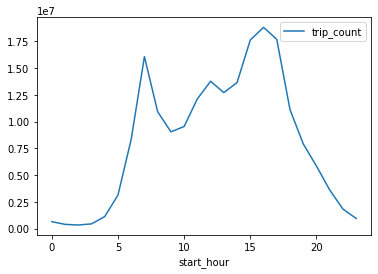

In [13]:
hourly_trip_count = inrix_skim.groupby('start_hour')[['trip_count']].sum()
hourly_trip_count.plot()

In [21]:
inrix_skim_am = inrix_skim.loc[inrix_skim['start_hour'] == 7]
inrix_skim_am = inrix_skim_am[['start_cbg', 'end_cbg', 
                               'trip_distance_mile', 'travel_time_h', 'trip_count']]
inrix_skim_am.columns = ['origin', 'destination', 
                         'inrix_dist_mile', 'inrix_time_hour', 'sample_size']
if region == 'Austin':
    beam_skim_out = beam_skim_out.rename(columns = {'origTaz':'origin',
                                          'destTaz': 'destination'})
beam_skim_compare = pd.merge(beam_skim_out,
                             inrix_skim_am,
                             on = ['origin', 'destination'],
                             how = 'inner')
print(len(beam_skim_compare))
beam_skim_compare.head(5)

13627


,hour,mode,origin,destination,travelTimeInS,distanceInM,beam_dist_mile,beam_time_hour,inrix_dist_mile,inrix_time_hour,sample_size
0,7,CAR,484530024221,484530011001,850.0,10059.7110,6.250803,0.236111,6.633690,0.675386,18
1,7,CAR,484910203231,484530018491,1732.0,26022.4970,16.169599,0.481111,14.054463,0.846389,1
2,7,CAR,484530009023,484530009012,141.0,1618.4520,1.005658,0.039167,1.117930,0.084074,3
3,7,CAR,484530018553,484910208051,679.5,10946.7185,6.801962,0.188750,7.986754,0.347421,14
4,7,CAR,484530018411,484530018531,506.0,6686.1585,4.154578,0.140556,4.855038,0.414074,3


In [16]:
beam_skim_out.columns

Index(['hour', 'mode', 'origTaz', 'destTaz', 'travelTimeInS', 'distanceInM',
       'beam_dist_mile', 'beam_time_hour'],
      dtype='object')

In [20]:
print(beam_skim_compare.sample_size.sum())

1047124


In [22]:
dist_r2 = r2_score(beam_skim_compare['inrix_dist_mile'], 
                  beam_skim_compare['beam_dist_mile'])
print('r2 score for routed distance ' + str(np.round(dist_r2, 2)))

time_r2 = r2_score(beam_skim_compare['inrix_time_hour'], 
                  beam_skim_compare['beam_time_hour'])
print('r2 score for routed travel time ' + str(np.round(time_r2, 2)))

r2 score for routed distance 0.69
r2 score for routed travel time 0.12


In [32]:
print(np.round(beam_skim_compare['inrix_dist_mile'].mean(), 2),
      np.round(beam_skim_compare['beam_dist_mile'].mean(), 2),
     np.round(beam_skim_compare['inrix_time_hour'].mean(), 2),
     np.round(beam_skim_compare['beam_time_hour'].mean())

8.763428082143934 7.86806109206099 0.40945153240844684 0.24158410484779666


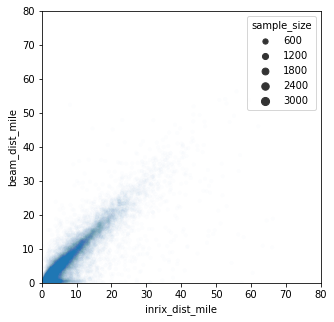

In [25]:

plt.figure(figsize = (5,5))
sns.scatterplot(data=beam_skim_compare, x="inrix_dist_mile", 
                y="beam_dist_mile", alpha = 0.01, 
                size = 'sample_size')
plt.xlim([0,80])
plt.ylim([0,80])
plt.show()

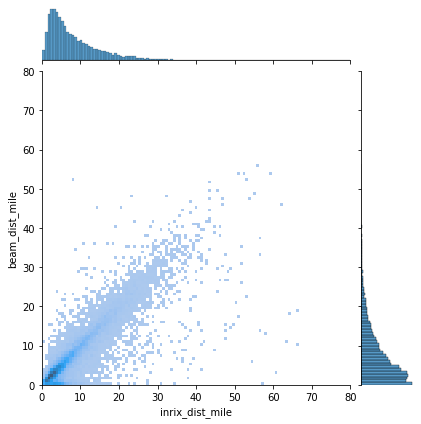

In [30]:
sns.jointplot(data=beam_skim_compare, x="inrix_dist_mile", 
                y="beam_dist_mile", kind="hist")
plt.xlim([0,80])
plt.ylim([0,80])
plt.savefig('plots/Aus_travel_dist_skim_validation.png', dpi = 300, 
           bbox_inches = 'tight')
plt.show()

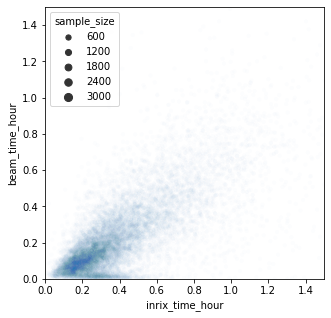

In [28]:
plt.figure(figsize = (5,5))
sns.scatterplot(data=beam_skim_compare, x="inrix_time_hour", 
                y="beam_time_hour", alpha = 0.01, 
                size = 'sample_size')
plt.xlim([0,1.5])
plt.ylim([0,1.5])
plt.show()

In [29]:
print(len(beam_skim_compare.origin.unique()))
print(len(beam_skim_compare.destination.unique()))

991
989


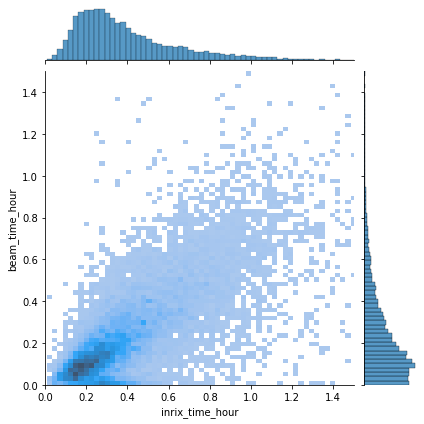

In [31]:
sns.jointplot(data=beam_skim_compare, x="inrix_time_hour", 
                y="beam_time_hour", kind="hist")
plt.xlim([0,1.5])
plt.ylim([0,1.5])
plt.savefig('plots/aus_travel_time_skim_validation.png', dpi = 300, 
           bbox_inches = 'tight')
plt.show()

In [21]:
beam_skim_out.to_csv('RawData/travel_skim_beam.csv.zip')